In [2]:
#export
from exp.nb_07 import * 

In [3]:
from fastai.vision import * 

In [6]:
import fastai

In [7]:
fastai.__version__

'2.2.7'

In [14]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE_160)

In [15]:
path.ls()

(#4) [Path('/home/.fastai/data/imagenette2-160/.DS_Store'),Path('/home/.fastai/data/imagenette2-160/train'),Path('/home/.fastai/data/imagenette2-160/noisy_imagenette.csv'),Path('/home/.fastai/data/imagenette2-160/val')]

In [10]:
#export
import PIL,os,mimetypes

In [16]:
(path/'val').ls()

(#10) [Path('/home/.fastai/data/imagenette2-160/val/n03394916'),Path('/home/.fastai/data/imagenette2-160/val/n03417042'),Path('/home/.fastai/data/imagenette2-160/val/n03445777'),Path('/home/.fastai/data/imagenette2-160/val/n02102040'),Path('/home/.fastai/data/imagenette2-160/val/n03425413'),Path('/home/.fastai/data/imagenette2-160/val/n03888257'),Path('/home/.fastai/data/imagenette2-160/val/n03028079'),Path('/home/.fastai/data/imagenette2-160/val/n03000684'),Path('/home/.fastai/data/imagenette2-160/val/n01440764'),Path('/home/.fastai/data/imagenette2-160/val/n02979186')]

In [17]:
path_tench = path/'val'/'n01440764'

In [23]:
img_fn = path_tench.ls()[2]
img_fn

Path('/home/.fastai/data/imagenette2-160/val/n01440764/n01440764_910.JPEG')

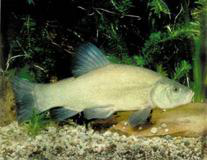

In [24]:
img = PIL.Image.open(img_fn)
img

In [25]:
import numpy
imga = numpy.array(img)

In [26]:
print(imga.shape)
imga[:10,:10,0]

(160, 207, 3)


array([[91,  6,  8,  2,  5,  3,  2,  5,  3,  3],
       [89,  4,  6,  1,  4,  2,  0,  3,  2,  2],
       [87,  2,  5,  0,  3,  1,  0,  2,  1,  1],
       [86,  2,  5,  0,  4,  1,  0,  2,  1,  1],
       [86,  2,  6,  2,  6,  3,  1,  3,  3,  3],
       [85,  2,  6,  2,  6,  4,  1,  3,  3,  3],
       [83,  0,  5,  1,  6,  3,  0,  1,  2,  2],
       [81,  0,  3,  0,  4,  2,  0,  0,  1,  1],
       [65,  4,  2,  0,  6,  0,  4,  2,  0,  0],
       [64,  4,  2,  0,  6,  0,  4,  2,  2,  4]], dtype=uint8)

In [27]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

' '.join(image_extensions)

'.jpx .ico .ief .djvu .pat .jng .nef .art .xbm .jpeg .cpt .bmp .rgb .jpg2 .cdt .xwd .wbmp .cdr .png .cr2 .tiff .jpg .pcx .pgm .tif .orf .ras .psd .svg .jpe .gif .jpf .jp2 .svgz .pnm .erf .pbm .djv .crw .ppm .jpm .xpm'

In [28]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [29]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

In [30]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [31]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[Path('/home/.fastai/data/imagenette2-160/n01440764_32420.JPEG'),
 Path('/home/.fastai/data/imagenette2-160/n01440764_4562.JPEG'),
 Path('/home/.fastai/data/imagenette2-160/n01440764_910.JPEG')]

In [33]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [36]:
get_files(path_tench, image_extensions)[:3]

[Path('/home/.fastai/data/imagenette2-160/val/n01440764/n01440764_32420.JPEG'),
 Path('/home/.fastai/data/imagenette2-160/val/n01440764/n01440764_4562.JPEG'),
 Path('/home/.fastai/data/imagenette2-160/val/n01440764/n01440764_910.JPEG')]

In [40]:
all_files = get_files(path, image_extensions, recurse=True)
len(all_files)

13394

## Get Files 

In [41]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

In [42]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [44]:
il = ImageList.from_files(path,tfms=make_rgb)

In [52]:
from IPython.display import Image
from IPython.display import display


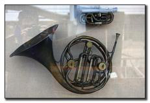
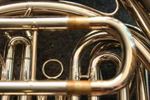
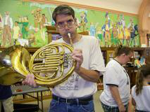
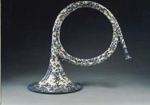
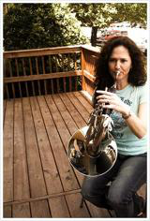
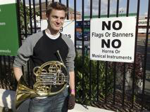
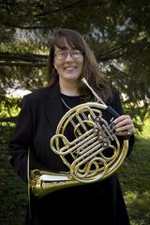
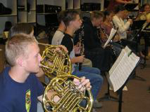
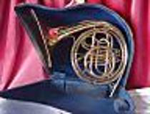
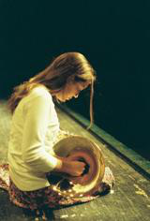


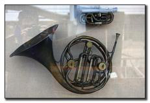
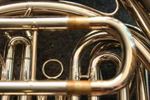
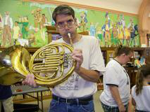
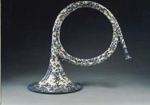
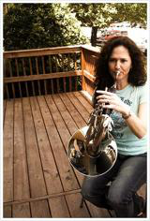
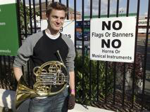
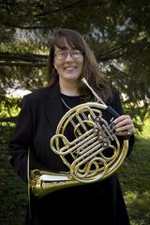
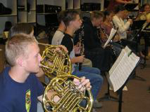
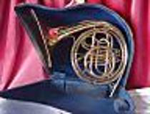
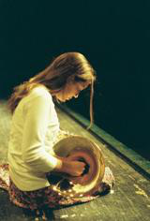

In [58]:
import ipyplot

ipyplot.plot_images(il[:10], img_width=150)

## Create ValidationSet 

In [81]:
len(il)

13394

In [89]:
fn = il.items[0]; fn.parent.parent.name, fn 

('train',
 Path('/home/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'))

In [90]:
fn.parent.parent.name

'train'

In [97]:
arr = [il.items[0],il.items[-1]];arr

[Path('/home/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'),
 Path('/home/.fastai/data/imagenette2-160/val/n02979186/ILSVRC2012_val_00042982.JPEG')]

In [107]:
[splitter(x) for x in arr]

train
train


[False, False]

In [113]:
#export 
def grandparent_splitter(fn,valid_name='valid',train_name='train'):
    gp = fn.parent.parent.name
    return True if gp == valid_name else False if gp == train_name else None 

splitter(fn)

train


False

In [114]:
def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    f = [o for o,m in zip(items,mask) if m==False]
    t = [o for o,m in zip(items,mask) if m==True ]
    return f,t

In [115]:
splitter = partial(grandparent_splitter,valid_name='val')

In [116]:
train,valid = split_by_func(il,splitter)

In [112]:
len(train),len(valid)

(9469, 3925)

In [117]:
#export
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    def __getattr__(self,k): return getattr(self.train,k)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [118]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (9469 items)
[Path('/home/.fastai/data/imagenette2-160/train/n03394916/ILSVRC2012_val_00046669.JPEG'), Path('/home/.fastai/data/imagenette2-160/train/n03394916/n03394916_58454.JPEG'), Path('/home/.fastai/data/imagenette2-160/train/n03394916/n03394916_32588.JPEG'), Path('/home/.fastai/data/imagenette2-160/train/n03394916/n03394916_33663.JPEG'), Path('/home/.fastai/data/imagenette2-160/train/n03394916/n03394916_27948.JPEG'), Path('/home/.fastai/data/imagenette2-160/train/n03394916/n03394916_38644.JPEG'), Path('/home/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), Path('/home/.fastai/data/imagenette2-160/train/n03394916/n03394916_38214.JPEG'), Path('/home/.fastai/data/imagenette2-160/train/n03394916/n03394916_23008.JPEG'), Path('/home/.fastai/data/imagenette2-160/train/n03394916/n03394916_33008.JPEG')...]
Path: /home/.fastai/data/imagenette2-160
Valid: ImageList (3925 items)
[Path('/home/.fastai/data/imagenette2-160/val/n03394916/n03394916_3

## Labelling

In [120]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

In [121]:
#export
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]
    
class ProcessedItemList(ListContainer):
    def __init__(self,inputs,processor):
        self.processor = processor
        items = self.processor.process(inputs)
        super().__init__(items)
        
    def obj(self,idx):
        res = self[idx]
        if isinstance(res,(tuple,list,Generator)): return self.processor.deprocess(res)
        return self.processor.deproc1(idx)

In [122]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [123]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [124]:
assert ll.train.proc_y is ll.valid.proc_y

In [125]:
ll.train.y

ItemList (9469 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /home/.fastai/data/imagenette2-160